In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
x = np.arange(-5, 5, 0.1)
y = f(x)

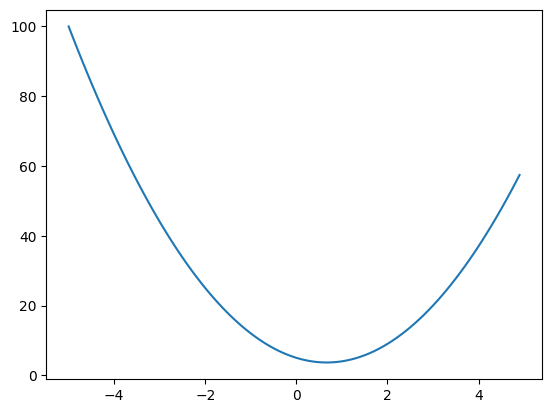

In [5]:
plt.plot(x, y)

In [6]:
# slope by intuition
h = 0.00000001
x = 2/3
df = (f(x+h) - f(x))/h
df

0.0

In [7]:
# more cases
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.00000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c

print(f'd1 : {d1}')
print(f'd2 : {d2}')
print(f' Slope : {(d2 - d1)/h}')

d1 : 4.0
d2 : 3.99999997
 Slope : -2.999999981767587


In [9]:
d3 = a*b + c
b += h
d4 = a*b + c

print(f'd3 : {d3}')
print(f'd4 : {d4}')
print(f' Slope : {(d4 - d3)/h}')

d3 : 3.99999997
d4 : 3.99999999
 Slope : 1.999999987845058


## Neural Networks

In [10]:
class Value :
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None # this will do the chain rule for back_prop

    def __repr__(self):
        return f"Value(data = {self.data:7f})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self+other

    def __sub__(self, other):
        return self + (-1 * other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self*other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power can be int/float only"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**-1)
        
    def tanh(self):
        k = self.data
        temp = (math.exp(2*k) - 1)/(math.exp(2*k) + 1)
        out = Value(temp, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - temp**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        k = self.data
        out = Value(math.exp(k), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
        

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

    

In [11]:
a = Value(3.0, label='a')
b = 2*a; b.label='b'
a - b

Value(data = -3.000000)

In [12]:
from graphviz import Digraph

def trace(root):
    # building set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if(v not in nodes):
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'dpi' : '50'}) # LR -> Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for every value sin graph create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s |  data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this values is a result of some operation, create a node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)

    return dot

#### Manual Back_propogation
<p>
l = d * f <br>
we need to find dl/dd <br>
and, dl/dt = (f(x+h) - f(x))/h , where Lim h->0 <br>
           = (f(d+h) - f(d))/h = (d*f + h*f - d*f)/h <br>
           = h*f / h <br>
           = f <br>


Now, we need dl/dc. for that lets check the effect of c on d  <br>
d = e+c  <br>
dd/dc = (f(c+h) - f(c))/h <br>
      = (e+c+h -e-c)/h <br>
      = 1.0 <br>

then dl/dc = (dl/dd) * (dd/dc) <br>
 dl/dc = f <br>

Now for dl/da, and dl/db : <br>
e = a * b <br>
de/da = b <br>
de/db = a <br>

thus dl/da = f*b <br>
and, dl/db = f*a <br>
</p>

In [13]:
# Manual Back_propogation again but with Neuron
# A basic neuron :
# Inputs x1, and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(4.71239123, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
s = x1w1 + x2w2; s.label = 'x1*w1 + x2*w2'
n = s + b; n.label = 'n'

# Activation function
# f = n.tanh(); 
e = (2*n).exp(); label= 'e'
f = (e - 1) / (e + 1)

f.label = 'f'
f.backward()

<p>
f = tanh(n) <br>
df/dn = 1 - tanh(n)**2 = 1-f**2 <br> 

Now df/db = df/dn * dn/db = 0.263 * 1.0 = 0.263 <br> 
same for df/ds <br> 
    
Now df/dx1w1 = df/ds * ds/x1w1 <br>
= 0.263 * 1,0  = 0.263 <br>
similarly, df/x2w2 = 0.263 * x1w1 = -1.578 <br>

Now, <br>
df/w1 = df/x1w1 * dx1w1/dw1 = 0.263 * x1 = 0.526 <br>
df/w2 = df/x2w2 * dx2w2/dw2 = 0.263 * x2 = 0.0 <br>
df/x1 = df/x1w1 * dx1w1/dx1 = 0.263 * w1 = -0.789 <br>
df/x2 = df/x2w2 * dx2w2/dx2 = 0.263 * w2 = 0.263 <br>

</p>

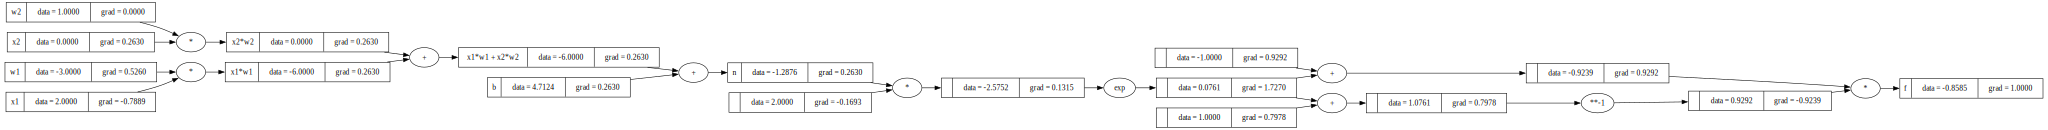

In [14]:
draw_dot(f)

In [15]:
# Lets do this backward pass automatically
# for this we implement topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

In [16]:
f.grad = 1.0
build_topo(f)
for node in reversed(topo):
    node._backward()

In [17]:
# My Neural Network
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def params(self):
      return self.w + [self.b]
  

class Layer:   
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def params(self):
    return [p for n in self.neurons for p in n.params()]


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

  def params(self):
    return [p for l in self.layers for p in l.params()]



x = [2.0, 3.0]
n = MLP(2, [4, 3, 2])
n(x)

[Value(data = 0.002865), Value(data = -0.543215)]

In [18]:
X = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y = [1.0, 0.0, 0.0, 1.0] # output(y) Binary classifer
n = MLP(3, [4, 3, 5, 1])


In [19]:
epochs = 1000
lr = 0.07
for k in range(epochs):
  
  # forward pass
  y_cap = [n(x) for x in X]
  loss = sum((ypred - yorg)**2 for yorg, ypred in zip(y, y_cap)) / len(y)
  
  # backward pass
  for p in n.params():
    p.grad = 0.0

  loss.backward()
  
  # update
  for p in n.params():
    p.data -= lr * p.grad
    
  if loss.data < 0.0001:
      print(f"Epoch {k+1}, Loss: {loss.data:.5f}")
      break

print(f"Epoch {epochs}, Loss: {loss.data:.5f} ")

Epoch 1000, Loss: 0.00022 


In [20]:
y_cap

[Value(data = 0.980049),
 Value(data = 0.000074),
 Value(data = 0.000384),
 Value(data = 0.978094)]